## Fine Tune a PreTrain a BERT model for Binary classification
Before this, the data must be processed, tokenized and prepared. Next, we need a pretrained bert model.
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model
3. `data_prepare` notebook prepares datasets for BERT models
4. `pretrain_bert` notebook conducts pretraining of BERT model

Here, we will use training and validation dataset for fine-tuning. Then test set is used for evaluation
### 1. Import libraries

In [7]:
import os
import joblib
from modules.bert_module import *
from modules.path_module import *
from transformers import BertForMaskedLM
from torch import cuda
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

### 2. Load datasets
We are going to use the validation set for training the fine-tune model. The training set for the pre-trained model will be used with labels as a validation.

In [8]:
train_dataset=joblib.load( os.path.join(bert_datapath,"val_data.joblib"))
val_dataset=joblib.load( os.path.join(bert_datapath,"train_data.joblib"))
test_dataset=joblib.load(os.path.join(bert_datapath,"test_data.joblib"))

### 3. Create Fine-tune classification model

In [9]:
model = BertForMaskedLM.from_pretrained(bert_modelpath)
print('PreTrained Model loaded')
# use GPU
device='cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# Instantiate the classification model
num_classes = 2  # Number of classes in classification task
classification_model = BertForSequenceClassification(model, num_classes,device)
classification_model.to(device)  # Move model to the device (e.g., GPU if available)
print('FineTune Model created')

PreTrained Model loaded
Running on: cuda
FineTune Model created


### 4. Configure Training 

In [10]:
num_epochs = 64 #128
training_batch_size=1
learning_rate=5e-6 #5e-6#2e-6
# Define optimizer and loss function
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()#nn.CrossEntropyLoss()
bert_finetune_modelfullpath=os.path.join(bert_finetune_modelpath,'finetune_bert.pt')

### 5. Create DataLoaders

In [11]:
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 6. Train and evaluate via validation set
We train using the training set and save the model that gives the best performance on the validation set

In [6]:
# Training loop
average_epoch_loss_all=[]
acc_train_all=[]
acc_val_all=[]
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    classification_model.train()
    epoch_loss = 0.0  # Initialize epoch loss
    num_batches = len(train_loader)

    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as progress_bar:
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            # Convert labels to float type
            labels = labels.float()
            optimizer.zero_grad()
            logits = classification_model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            probs_normalized = probs / probs.sum(dim=1, keepdim=True)
            loss = criterion(probs_normalized, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({'Loss': loss.item()})
            progress_bar.update()

    # Calculate and print average epoch loss
    average_epoch_loss = epoch_loss / num_batches
    #print(f'Epoch {epoch + 1} - Average Loss: {average_epoch_loss:.4f}')
    average_epoch_loss_all.append(average_epoch_loss)
    # Switch to evaluation mode for accuracy calculation
    classification_model.eval()
    # Calculate training accuracy
    accuracy, _ , _ , _= evaluate_binary_accuracy(classification_model, train_loader,device)
    acc_train_all.append(accuracy)
    # Calculate validation accuracy
    v_accuracy, _ , _ , _ = evaluate_binary_accuracy(classification_model, val_loader,device)
    acc_val_all.append(v_accuracy)
    # Check if current validation accuracy is the best
    if v_accuracy > best_val_accuracy:
        best_val_accuracy = v_accuracy
        torch.save(classification_model.state_dict(),bert_finetune_modelfullpath) # Save the model state
        print(f'model state saved with validation accuracy: {best_val_accuracy:.4f}')
    # Switch back to training mode for the next epoch
    classification_model.train()

print('Fine tune completed')

Epoch 1/64: 100%|██████████| 138/138 [00:05<00:00, 23.68batch/s, Loss=0.621]


model state saved


Epoch 2/64: 100%|██████████| 138/138 [00:05<00:00, 24.05batch/s, Loss=0.817]


model state saved


Epoch 3/64: 100%|██████████| 138/138 [00:05<00:00, 24.23batch/s, Loss=0.485]


model state saved


Epoch 4/64: 100%|██████████| 138/138 [00:05<00:00, 24.15batch/s, Loss=0.608]


model state saved


Epoch 5/64: 100%|██████████| 138/138 [00:05<00:00, 24.11batch/s, Loss=0.231]


model state saved


Epoch 6/64: 100%|██████████| 138/138 [00:05<00:00, 23.95batch/s, Loss=0.397]


model state saved


Epoch 7/64: 100%|██████████| 138/138 [00:05<00:00, 24.22batch/s, Loss=0.114]


model state saved


Epoch 9/64: 100%|██████████| 138/138 [00:05<00:00, 24.26batch/s, Loss=0.237]


model state saved


Epoch 14/64: 100%|██████████| 138/138 [00:05<00:00, 24.32batch/s, Loss=0.114] 


model state saved


Epoch 15/64: 100%|██████████| 138/138 [00:05<00:00, 23.11batch/s, Loss=0.0338]


model state saved


Epoch 16/64: 100%|██████████| 138/138 [00:05<00:00, 24.05batch/s, Loss=0.329] 


model state saved


Epoch 18/64: 100%|██████████| 138/138 [00:05<00:00, 24.60batch/s, Loss=0.108] 


model state saved


Epoch 20/64: 100%|██████████| 138/138 [00:05<00:00, 24.55batch/s, Loss=0.0231] 


model state saved


Epoch 21/64: 100%|██████████| 138/138 [00:05<00:00, 24.52batch/s, Loss=0.0194] 


model state saved


Epoch 26/64: 100%|██████████| 138/138 [00:05<00:00, 23.91batch/s, Loss=0.00561]


model state saved


Epoch 42/64: 100%|██████████| 138/138 [00:05<00:00, 24.39batch/s, Loss=0.00746]


model state saved


Epoch 64/64: 100%|██████████| 138/138 [00:05<00:00, 24.58batch/s, Loss=0.00401] 


Fine tune completed


Let's plot the training and validation loss

<function matplotlib.pyplot.show(close=None, block=None)>

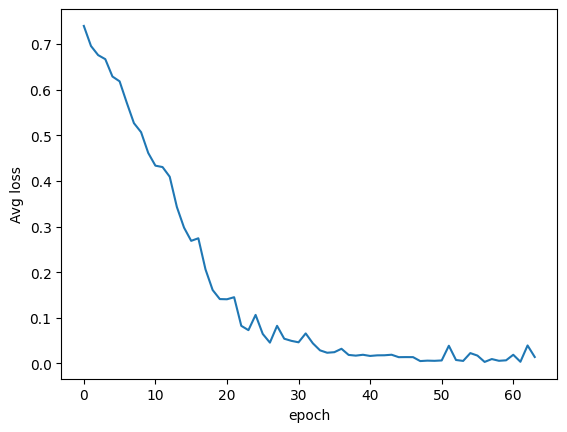

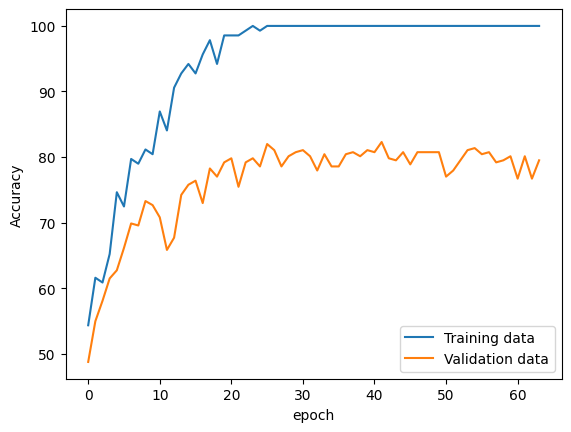

In [7]:
plt.figure()
plt.plot(average_epoch_loss_all)
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show


plt.figure()
plt.plot(acc_train_all,label='Training data')
plt.plot(acc_val_all,label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show

### 7. Evaluate model

In [12]:
best_model_state=torch.load(bert_finetune_modelfullpath, map_location=device)
classification_model.load_state_dict(best_model_state,strict=True)
classification_model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(classification_model, train_loader,device)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(classification_model, val_loader,device)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(classification_model, test_loader,device)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 100.0000
Confusion Matrix:
[[72  0]
 [ 0 66]]
Accuracy: 100.0
Precision: 100.0
Sensitivity (Recall): 100.0
Specificity: 100.0
F1 Score: 1.0
AUC Score: 1.0


Validation Binary Accuracy: 82.2981
Confusion Matrix:
[[147  21]
 [ 36 118]]
Accuracy: 82.29813664596274
Precision: 84.89208633093526
Sensitivity (Recall): 76.62337662337663
Specificity: 87.5
F1 Score: 0.8054607508532423
AUC Score: 0.860273654916512


Test Binary Accuracy: 78.2609
Confusion Matrix:
[[41  7]
 [13 31]]
Accuracy: 78.26086956521739
Precision: 81.57894736842105
Sensitivity (Recall): 70.45454545454545
Specificity: 85.41666666666666
F1 Score: 0.7560975609756098
AUC Score: 0.8214962121212122
Completed
